In [1]:
# Install dependencies (if needed)
!pip install torch torchvision tqdm --quiet

In [2]:
# Import libraries
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
# Define KANLinear and KAN
class KANLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, grid_size=5, spline_order=3,
                 scale_noise=0.1, scale_base=1.0, scale_spline=1.0,
                 enable_standalone_scale_spline=True, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = self.grid
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(0, 1)
        B = y.transpose(0, 1)
        solution = torch.linalg.lstsq(A, B).solution
        result = solution.permute(2, 0, 1)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

class KAN(torch.nn.Module):
    def __init__(self, layers_hidden, grid_size=5, spline_order=3, scale_noise=0.1,
                 scale_base=1.0, scale_spline=1.0, base_activation=torch.nn.SiLU,
                 grid_eps=0.02, grid_range=[-1, 1]):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor):
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
# Define the Generator and Discriminator
class Generator(KAN):
    def __init__(self, noise_dim, output_dim, layers_hidden):
        super(Generator, self).__init__(layers_hidden=[noise_dim] + layers_hidden + [output_dim])

    def forward(self, x):
        x = super().forward(x)
        return torch.tanh(x)  # Scale output to [-1, 1]

class Discriminator(KAN):
    def __init__(self, input_dim, layers_hidden):
        super(Discriminator, self).__init__(layers_hidden=[input_dim] + layers_hidden + [1])

    def forward(self, x):
        x = super().forward(x)
        return torch.sigmoid(x)  # Output probability

In [5]:
# Hyperparameters
noise_dim = 100
image_dim = 28 * 28  # Flattened MNIST images
generator_hidden_layers = [256, 512, 1024]
discriminator_hidden_layers = [1024, 512, 256]
batch_size = 64
lr = 2e-4
epochs = 50

In [6]:
# Load MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Initialize Generator and Discriminator
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(noise_dim, image_dim, generator_hidden_layers).to(device)
discriminator = Discriminator(image_dim, discriminator_hidden_layers).to(device)

# Optimizers
optimizer_g = optim.AdamW(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_d = optim.AdamW(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 42.9MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.24MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.6MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.91MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()

    for real_images, _ in tqdm(trainloader, desc=f"Epoch {epoch + 1}/{epochs}"):
        real_images = real_images.view(-1, image_dim).to(device)

        # Create labels
        batch_size = real_images.size(0)
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)

        discriminator_real = discriminator(real_images)
        discriminator_fake = discriminator(fake_images.detach())

        loss_d_real = criterion(discriminator_real, real_labels)
        loss_d_fake = criterion(discriminator_fake, fake_labels)
        loss_d = loss_d_real + loss_d_fake

        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step()

        # Train Generator
        noise = torch.randn(batch_size, noise_dim).to(device)
        fake_images = generator(noise)
        discriminator_fake = discriminator(fake_images)

        loss_g = criterion(discriminator_fake, real_labels)

        optimizer_g.zero_grad()
        loss_g.backward()
        optimizer_g.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss D: {loss_d:.4f}, Loss G: {loss_g:.4f}")

Epoch 1/50: 100%|██████████| 938/938 [00:49<00:00, 18.92it/s]


Epoch 1/50, Loss D: 0.0089, Loss G: 6.2659


Epoch 2/50: 100%|██████████| 938/938 [00:48<00:00, 19.51it/s]


Epoch 2/50, Loss D: 0.0001, Loss G: 9.1307


Epoch 3/50: 100%|██████████| 938/938 [00:47<00:00, 19.62it/s]


Epoch 3/50, Loss D: 0.0007, Loss G: 8.3033


Epoch 4/50: 100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


Epoch 4/50, Loss D: 0.0118, Loss G: 6.1331


Epoch 5/50: 100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 5/50, Loss D: 0.1587, Loss G: 5.1442


Epoch 6/50: 100%|██████████| 938/938 [00:47<00:00, 19.69it/s]


Epoch 6/50, Loss D: 0.0680, Loss G: 4.2758


Epoch 7/50: 100%|██████████| 938/938 [00:48<00:00, 19.47it/s]


Epoch 7/50, Loss D: 0.1435, Loss G: 3.2741


Epoch 8/50: 100%|██████████| 938/938 [00:48<00:00, 19.48it/s]


Epoch 8/50, Loss D: 0.0005, Loss G: 7.9584


Epoch 9/50: 100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 9/50, Loss D: 0.1667, Loss G: 3.5262


Epoch 10/50: 100%|██████████| 938/938 [00:47<00:00, 19.57it/s]


Epoch 10/50, Loss D: 0.1674, Loss G: 2.8396


Epoch 11/50: 100%|██████████| 938/938 [00:47<00:00, 19.61it/s]


Epoch 11/50, Loss D: 0.2224, Loss G: 2.5453


Epoch 12/50: 100%|██████████| 938/938 [00:47<00:00, 19.59it/s]


Epoch 12/50, Loss D: 0.2641, Loss G: 3.6071


Epoch 13/50: 100%|██████████| 938/938 [00:47<00:00, 19.71it/s]


Epoch 13/50, Loss D: 0.2028, Loss G: 3.0561


Epoch 14/50: 100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


Epoch 14/50, Loss D: 0.5545, Loss G: 1.9408


Epoch 15/50: 100%|██████████| 938/938 [00:47<00:00, 19.76it/s]


Epoch 15/50, Loss D: 0.1478, Loss G: 2.9181


Epoch 16/50: 100%|██████████| 938/938 [00:47<00:00, 19.68it/s]


Epoch 16/50, Loss D: 0.3750, Loss G: 2.7125


Epoch 17/50: 100%|██████████| 938/938 [00:47<00:00, 19.67it/s]


Epoch 17/50, Loss D: 0.1157, Loss G: 3.1129


Epoch 18/50: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 18/50, Loss D: 0.2652, Loss G: 2.7582


Epoch 19/50: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 19/50, Loss D: 0.2640, Loss G: 2.7684


Epoch 20/50: 100%|██████████| 938/938 [00:47<00:00, 19.66it/s]


Epoch 20/50, Loss D: 0.2359, Loss G: 2.8381


Epoch 21/50: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 21/50, Loss D: 0.4037, Loss G: 2.4466


Epoch 22/50: 100%|██████████| 938/938 [00:47<00:00, 19.67it/s]


Epoch 22/50, Loss D: 0.4049, Loss G: 2.7959


Epoch 23/50: 100%|██████████| 938/938 [00:47<00:00, 19.55it/s]


Epoch 23/50, Loss D: 0.5412, Loss G: 2.5916


Epoch 24/50: 100%|██████████| 938/938 [00:47<00:00, 19.62it/s]


Epoch 24/50, Loss D: 0.4339, Loss G: 1.8998


Epoch 25/50: 100%|██████████| 938/938 [00:47<00:00, 19.71it/s]


Epoch 25/50, Loss D: 0.2952, Loss G: 2.5685


Epoch 26/50: 100%|██████████| 938/938 [00:47<00:00, 19.59it/s]


Epoch 26/50, Loss D: 0.3363, Loss G: 2.7654


Epoch 27/50: 100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


Epoch 27/50, Loss D: 0.2702, Loss G: 2.6489


Epoch 28/50: 100%|██████████| 938/938 [00:47<00:00, 19.56it/s]


Epoch 28/50, Loss D: 0.3792, Loss G: 2.8145


Epoch 29/50: 100%|██████████| 938/938 [00:47<00:00, 19.61it/s]


Epoch 29/50, Loss D: 0.1764, Loss G: 2.4038


Epoch 30/50: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 30/50, Loss D: 0.3332, Loss G: 3.0771


Epoch 31/50: 100%|██████████| 938/938 [00:47<00:00, 19.66it/s]


Epoch 31/50, Loss D: 0.2638, Loss G: 3.0406


Epoch 32/50: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


Epoch 32/50, Loss D: 0.2122, Loss G: 2.4706


Epoch 33/50: 100%|██████████| 938/938 [00:47<00:00, 19.62it/s]


Epoch 33/50, Loss D: 0.2018, Loss G: 2.4251


Epoch 34/50: 100%|██████████| 938/938 [00:47<00:00, 19.56it/s]


Epoch 34/50, Loss D: 0.3957, Loss G: 2.7768


Epoch 35/50: 100%|██████████| 938/938 [00:47<00:00, 19.68it/s]


Epoch 35/50, Loss D: 0.2021, Loss G: 2.3566


Epoch 36/50: 100%|██████████| 938/938 [00:47<00:00, 19.64it/s]


Epoch 36/50, Loss D: 0.2238, Loss G: 2.7750


Epoch 37/50: 100%|██████████| 938/938 [00:47<00:00, 19.60it/s]


Epoch 37/50, Loss D: 0.3052, Loss G: 2.5127


Epoch 38/50: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


Epoch 38/50, Loss D: 0.1838, Loss G: 2.7755


Epoch 39/50: 100%|██████████| 938/938 [00:47<00:00, 19.56it/s]


Epoch 39/50, Loss D: 0.2570, Loss G: 2.6867


Epoch 40/50: 100%|██████████| 938/938 [00:47<00:00, 19.66it/s]


Epoch 40/50, Loss D: 0.2831, Loss G: 2.3611


Epoch 41/50: 100%|██████████| 938/938 [00:47<00:00, 19.62it/s]


Epoch 41/50, Loss D: 0.5524, Loss G: 1.9131


Epoch 42/50: 100%|██████████| 938/938 [00:47<00:00, 19.67it/s]


Epoch 42/50, Loss D: 0.2106, Loss G: 2.7195


Epoch 43/50: 100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 43/50, Loss D: 0.5330, Loss G: 2.0223


Epoch 44/50: 100%|██████████| 938/938 [00:47<00:00, 19.72it/s]


Epoch 44/50, Loss D: 0.1576, Loss G: 2.6129


Epoch 45/50: 100%|██████████| 938/938 [00:47<00:00, 19.58it/s]


Epoch 45/50, Loss D: 0.1344, Loss G: 2.5773


Epoch 46/50: 100%|██████████| 938/938 [00:48<00:00, 19.54it/s]


Epoch 46/50, Loss D: 0.5633, Loss G: 2.6218


Epoch 47/50: 100%|██████████| 938/938 [00:47<00:00, 19.65it/s]


Epoch 47/50, Loss D: 0.5192, Loss G: 1.8355


Epoch 48/50: 100%|██████████| 938/938 [00:48<00:00, 19.52it/s]


Epoch 48/50, Loss D: 0.4083, Loss G: 2.2815


Epoch 49/50: 100%|██████████| 938/938 [00:47<00:00, 19.68it/s]


Epoch 49/50, Loss D: 0.1529, Loss G: 2.7775


Epoch 50/50: 100%|██████████| 938/938 [00:47<00:00, 19.64it/s]

Epoch 50/50, Loss D: 0.3518, Loss G: 2.6485


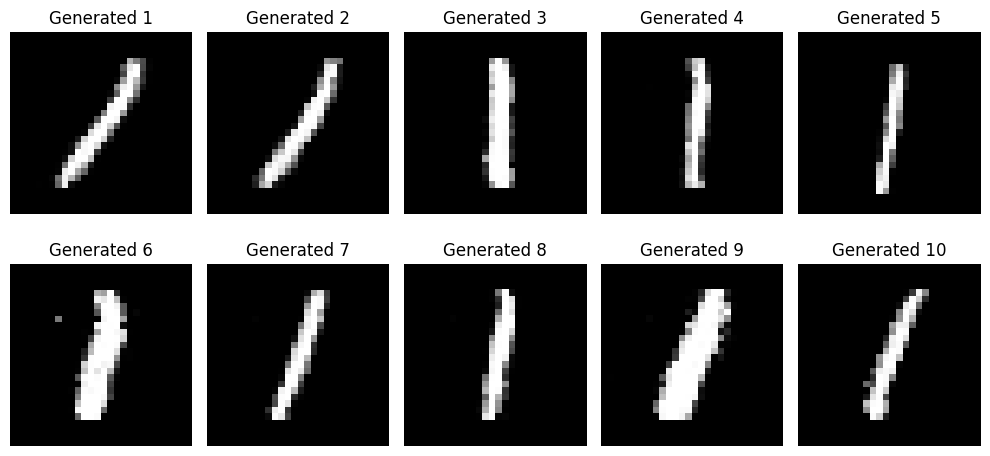

In [11]:
import matplotlib.pyplot as plt

# Helper function to display generated images
def display_generated_images(generator, num_images, noise_dim, device):
    # Generate noise
    noise = torch.randn(num_images, noise_dim).to(device)

    # Generate fake images
    with torch.no_grad():
        fake_images = generator(noise).view(-1, 28, 28).cpu()  # Reshape to 28x28

    # Plot the generated images
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        plt.subplot(2, 5, i + 1)  # Create a grid for 10 images
        plt.imshow(fake_images[i], cmap="gray")
        plt.axis("off")
        plt.title(f"Generated {i + 1}")
    plt.tight_layout()
    plt.show()

# Display 10 generated images
display_generated_images(generator, num_images=10, noise_dim=noise_dim, device=device)

In [12]:
# Path untuk menyimpan model
generator_path = "generator.pth"
discriminator_path = "discriminator.pth"

# Simpan state dictionary Generator dan Discriminator
torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

print(f"Models saved to {generator_path} and {discriminator_path}")

Models saved to generator.pth and discriminator.pth


In [14]:
# Load state dictionary
generator.load_state_dict(torch.load(generator_path))
discriminator.load_state_dict(torch.load(discriminator_path))

# Pastikan model dalam mode evaluasi (jika hanya digunakan untuk inferensi)
generator.eval()
discriminator.eval()

print("Models loaded successfully!")

Models loaded successfully!


<ipython-input-14-7c615ae6c527>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_path))
<ipython-input-14-7c615ae6c527>:3: Fut

In [15]:
# Simpan optimizer state
optimizer_g_path = "optimizer_g.pth"
optimizer_d_path = "optimizer_d.pth"

torch.save(optimizer_g.state_dict(), optimizer_g_path)
torch.save(optimizer_d.state_dict(), optimizer_d_path)

In [16]:
# Load optimizer state
optimizer_g.load_state_dict(torch.load(optimizer_g_path))
optimizer_d.load_state_dict(torch.load(optimizer_d_path))

<ipython-input-16-1b5f440c6759>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  optimizer_g.load_state_dict(torch.load(optimizer_g_path))
<ipython-input-16-1b5f440c6759>:3:

In [17]:
checkpoint_path = "gan_checkpoint.pth"

checkpoint = {
    "generator_state_dict": generator.state_dict(),
    "discriminator_state_dict": discriminator.state_dict(),
    "optimizer_g_state_dict": optimizer_g.state_dict(),
    "optimizer_d_state_dict": optimizer_d.state_dict(),
    "epoch": epoch,  # Simpan informasi epoch terakhir
}

torch.save(checkpoint, checkpoint_path)
print(f"Checkpoint saved to {checkpoint_path}")

Checkpoint saved to gan_checkpoint.pth


In [18]:
# Load checkpoint
checkpoint = torch.load(checkpoint_path)

# Restore model dan optimizer state
generator.load_state_dict(checkpoint["generator_state_dict"])
discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
optimizer_g.load_state_dict(checkpoint["optimizer_g_state_dict"])
optimizer_d.load_state_dict(checkpoint["optimizer_d_state_dict"])

# Ambil informasi epoch terakhir
epoch = checkpoint["epoch"]

print(f"Checkpoint loaded, starting from epoch {epoch}")

<ipython-input-18-2805ffeef34b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Checkpoint loaded, starting from epoch 49
